In [43]:
# Convolutional Neural Network

import tensorflow as tf
import tensorflow_datasets as tfds

In [44]:
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [45]:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='C:\\Users\\fabian\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Ha

In [46]:
# separemos los datos de entrenamiento de los datos de prueba en la base de datos 
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [47]:
nombres_clases = metadatos.features['label'].names

In [48]:
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [49]:
# Normalizacion de los datos (pasar de 0-255 a 0-1)

def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32)
    imagenes /= 255 # Aqui lo pasa de 0-255 a 0-1
    return imagenes, etiquetas

# Normalizar los datos de entrenamiento y pruenas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar los datos a cache (Usar memoria en lugar de disco)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

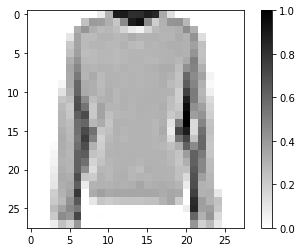

In [51]:
# mostrar imagenes de los datos de prueba, de momento mostramos la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
    break
imagen = imagen.numpy().reshape((28,28)) # Redimensionando, cosa de tensores, lo veremos despues

import matplotlib.pyplot as plt

#Dibujar imagen
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()


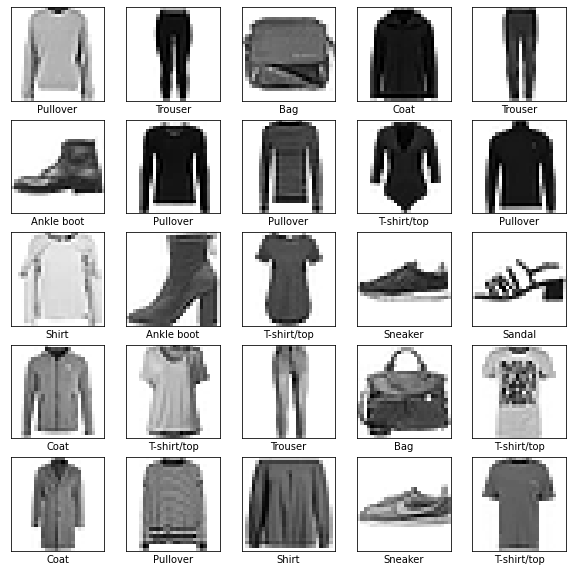

In [52]:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
    imagen = imagen.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagen, cmap=plt.cm.binary)
    plt.xlabel(nombres_clases[etiqueta])

plt.show()

# Creacion del modelo

In [53]:
# Crear modelo

modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28,28,1)), # la capa faltten combierte esta matrix y la aplazta en un vector de una sola dimension
    tf.keras.layers.Dense(50, activation = tf.nn.relu), # se agrega una capa oculta con funcion de activacion relu
    tf.keras.layers.Dense(50, activation = tf.nn.relu), # se agrega una capa oculta con funcion de activacion relu
    tf.keras.layers.Dense(10, activation = tf.nn.softmax), # se agrega una capa de salida con funcion de activacion softmax, para redes de clasificasion asegura suma en salida = 1
])

In [54]:
# Compilamos el modelo
modelo.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [55]:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [56]:
#podemos entrenar la red por lotes para optimizar el rendimiento
TAMANO_LOTE = 32

datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [57]:
# realizamos entrenamiento

import math

#Entrenamiento
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch= math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5150 - accuracy: 0.8171
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3883 - accuracy: 0.8585
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3459 - accuracy: 0.8716
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3264 - accuracy: 0.8791
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3088 - accuracy: 0.8863


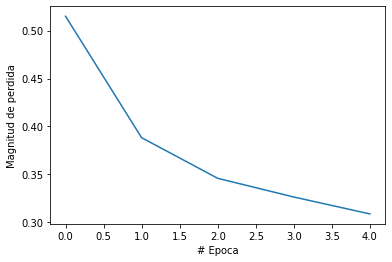

In [58]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de perdida")
plt.plot(historial.history["loss"])

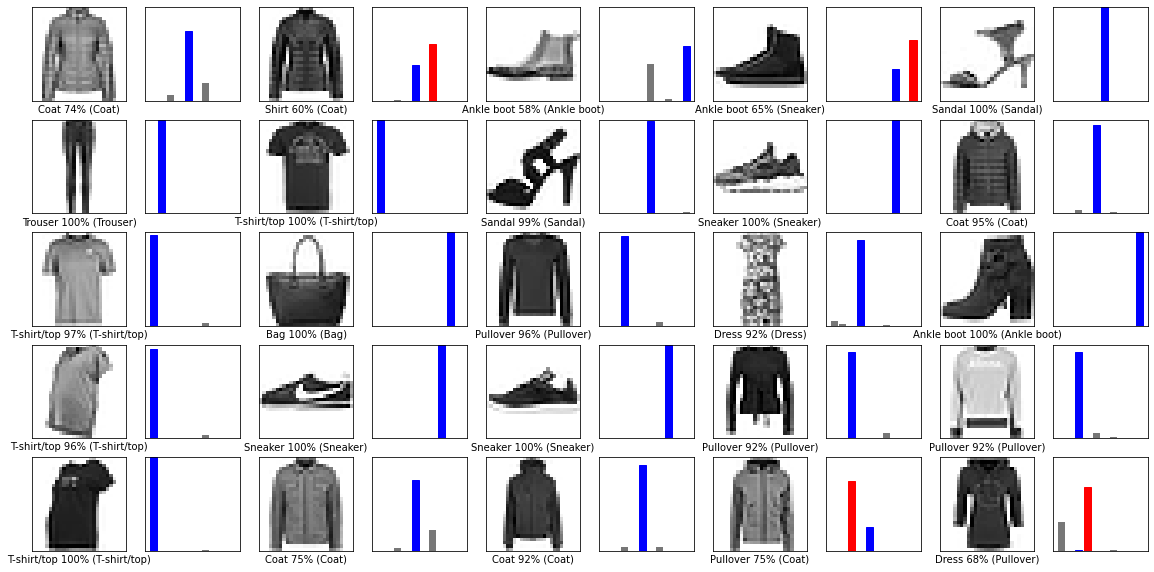

In [59]:
# mostrar algunas de las imagenes de prueba 

import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
    imagenes_prueba = imagenes_prueba.numpy()
    etiquetas_prueba = etiquetas_prueba.numpy()
    predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
    arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[..., 0], cmap=plt.cm.binary)

    etiqueta_prediccion = np.argmax(arr_predicciones)
    if etiqueta_prediccion == etiqueta_real:
        color = 'blue' # Si le atino
    else:
        color = 'red' #Oops, no le atino
    
    plt.xlabel("{} {:2.0f}% ({})".format(
        nombres_clases[etiqueta_prediccion],
        100*np.max(arr_predicciones),
        nombres_clases[etiqueta_real],
        color=color
    ))

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
    arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    grafica = plt.bar(range(10), arr_predicciones, color='#777777')
    plt.ylim([0,1])
    etiqueta_prediccion = np.argmax(arr_predicciones)

    grafica[etiqueta_prediccion].set_color('red')
    grafica[etiqueta_real].set_color('blue')

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
    plt.subplot(filas, 2*columnas, 2*i+1)
    graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
    plt.subplot(filas, 2*columnas, 2*i+2)
    graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [67]:
#Tomar cualquier indice del set de pruebas para ver su prediccion

num_imagen = 23

imagen = imagenes_prueba[num_imagen]
etiqueta = etiquetas_prueba[num_imagen]
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Predicciones: " + nombres_clases[np.argmax(prediccion[0])])
print("Real: " + nombres_clases[etiqueta])

Predicciones: Pullover
Real: Coat


# Exportacion del modelo

In [68]:
# Exportacion del modelo
modelo.save('modelo_exportado.h5')

In [74]:
#instalar tensorflowjs
!pip install tensorflowjs --user


  Using cached tensorflowjs-3.15.0-py3-none-any.whl (77 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [80]:
# convertir el archivo a formato de tensorflowjs
!mkdir tfjs_target_dir
!"C:\Users\fabian\AppData\Roaming\Python\Python310\Scripts\tensorflowjs_converter" --input_format keras modelo_exportado.h5 tfjs_target_dir

Ya existe el subdirectorio o el archivo tfjs_target_dir.
2022-04-13 17:46:52.535194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-13 17:46:52.535619: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
